## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SIM

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

**Usage**

```python
from pysim import SIM
clf = SIM(taks="Regression", method="first", spline="augbs", reg_lambda=0.1, reg_gamma=0.1, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Hyperparameters**

- task: the task type, including "Regression" and "Classification". default="Regression"

- method: the base method for estimating the projection coefficients in sparse SIM. default="first"

        "first": First-order Stein's Identity via sparse PCA solver

        "second": Second-order Stein's Identity via sparse PCA solver

        "first_thresholding": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="augbs"

        "ps": p-spline (from pygam package)
    
        "mono": p-spline with monotonic constraint (from pygam package)
    
        "augbs": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=0.1, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [19]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [20]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=50, spline="augbs", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed:   45.1s remaining:   59.0s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   52.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   53.2s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 50 s, sys: 1min 11s, total: 2min 1s
Wall time: 56.3 s


In [21]:
grid.best_params_

{'method': 'first', 'reg_gamma': 0.01, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [25]:
clf = grid.best_estimator_
clf

SIM(degree=2, knot_num=50, method='first', random_state=0, reg_gamma=0.01,
    reg_lambda=0.05, spline='augbs', task='Regression')

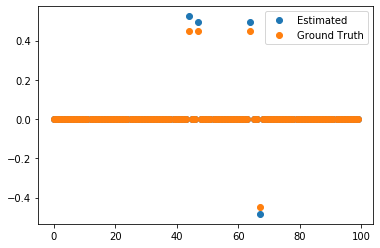

In [26]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

In [54]:
import scipy
from scipy.linalg import cholesky
from patsy import dmatrix, build_design_matrices

def diff_matrix(order, knot_num):
    results = [] # a container to collect the rows
    n_rows = order + 2
    for _ in range(n_rows): 
        row = [1] # a starter 1 in the row
        if results: # then we're in the second row or beyond
            last_row = results[-1] # reference the previous row
            row.extend([sum(pair) for pair in zip(last_row, last_row[1:])])
            row.append(1)
        results.append(row) # add the row to the results.

    diss_operator = [] # a container to collect the rows
    for i, item in enumerate(np.array(row)):
        diss_operator.append(item * (-1) ** i)
    diss_operator.reverse()
    D = np.zeros((knot_num, knot_num + order + 1), dtype=np.float32)
    for i in range(knot_num):
        D[i,i:(i+order+2)] = diss_operator
    return D

n_samples = x.shape[0]
sample_weight = np.ones(n_samples)

knots = list(np.linspace(clf.xmin_, clf.xmax_, clf.knot_num + 2, dtype=np.float32)[1:-1])
xphi = dmatrix("bs(x, knots = knots, degree=degree, include_intercept=True) - 1",
       {"x": [clf.xmin_, clf.xmax_], "knots": knots, "degree": clf.degree})
basis = np.asarray(build_design_matrices([xphi.design_info],
       {"x": x, "knots": knots, "degree": clf.degree})[0])
D = diff_matrix(clf.degree, clf.knot_num)
w = np.ones([clf.knot_num], dtype=np.float32) 
W = np.diag(w)

BB = basis.T.dot(np.diag(sample_weight)).dot(basis)
BY = basis.T.dot(np.diag(sample_weight)).dot(y)
for i in range(10):
    U = cholesky(BB + clf.reg_gamma * np.dot(np.dot(D.T, W), D))
    M = scipy.linalg.lapack.clapack.dtrtri(U)[0]
    update_a = np.dot(np.dot(M, M.T.conj()), BY)
    # The original implementation of matrix inversion is very slow and so it is commented. 
    # update_a = np.dot(np.linalg.inv(np.dot(basis.T, basis) + self.reg_gamma * np.dot(np.dot(D.T, W), D)), np.dot(basis.T, y))
    update_w = 1 / (np.dot(D, update_a) ** 2 + clf.link_fit_.epsilon ** 2)
    W = np.diag(update_w.reshape([-1]))

selected_knots_ = list(np.array(knots)[np.reshape(update_w * np.dot(D, update_a) ** 2 > 0.99, [-1])])
selected_knots_

[-1.0579944,
 -1.0123414,
 -0.87538254,
 -0.82972956,
 -0.78407663,
 -0.73842365,
 -0.6927707,
 -0.64711773,
 -0.6014648,
 -0.5558118,
 -0.5101589,
 -0.46450594,
 -0.41885298,
 -0.32754707,
 -0.28189412,
 -0.23624116,
 -0.1905882,
 -0.14493525,
 -0.099282295,
 -0.05362934,
 -0.007976382,
 0.037676573,
 0.08332953,
 0.12898248,
 0.17463544,
 0.26594135,
 0.35724726,
 0.40290022,
 0.44855317,
 0.49420613,
 0.53985906,
 0.63116497,
 0.67681795,
 0.7224709,
 0.76812387,
 0.8137768,
 0.8594298]

In [50]:
BB2 = basis.T.dot(basis)
BY1 = basis.T.dot(np.diag(sample_weight)).dot(y)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.55228950e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.90784516e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [51]:
BB1 = basis.T.dot(np.diag(sample_weight)).dot(basis)
BY1 = basis.T.dot(np.diag(sample_weight)).dot(y)
BB1.shape

(53, 53)

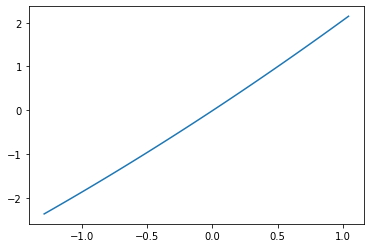

In [7]:
clf.visualize_shape_function()
plt.show()

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [8]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + np.random.randn(n_samples)

In [9]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.02, 0.04, 0.08, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=100, spline="augbs", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 174 out of 200 | elapsed:  2.6min remaining:   23.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 1min 3s, sys: 1min 31s, total: 2min 34s
Wall time: 2min 48s


In [10]:
grid.best_params_

{'method': 'second', 'reg_gamma': 0.01, 'reg_lambda': 0.02}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [11]:
clf = grid.best_estimator_
clf

SIM(degree=2, knot_num=100, method='second', random_state=0, reg_gamma=0.01,
    reg_lambda=0.02, spline='augbs', task='Regression')

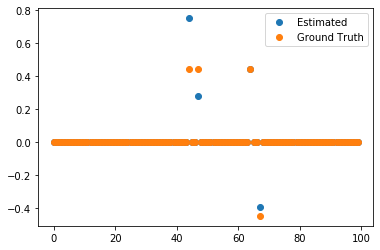

In [12]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

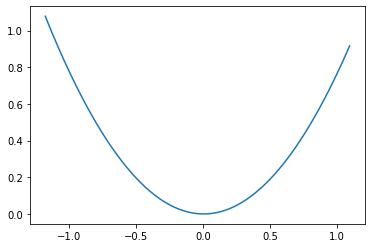

In [13]:
clf.visualize_shape_function()
plt.show()

## Case 3: Monotonic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = e^{-u} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [14]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.exp(- np.dot(x, beta)) + np.random.randn(n_samples)

- monotonic p-spline

In [15]:
%%time 

param_grid = {"method": ["first", "second"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma":  np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIM(task="Regression", degree=2, knot_num=50, spline="mono", random_state=0), 
                    cv=KFold(5, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed:   30.0s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed:   50.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.6s finished


CPU times: user 16.5 s, sys: 42.4 s, total: 58.9 s
Wall time: 53.5 s


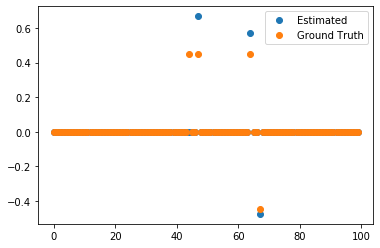

In [16]:
plt.plot(grid.best_estimator_.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

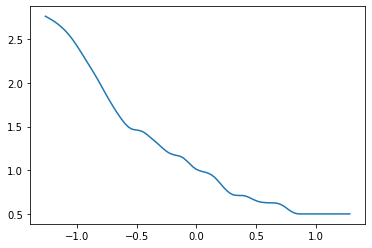

In [17]:
grid.best_estimator_.visualize_shape_function()
plt.show()